In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from time import time

from torchvision.datasets import MNIST, SVHN
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
import torch.nn as nn
import torch.nn.functional as F

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

True
device: cuda


# Let's check the datasets

In [3]:
# Téléchargement des datasets MNIST
mnist_train = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Téléchargement des datasets SVHN
svhn_train = SVHN(root='./data', split='train', download=True, transform=transforms.ToTensor())
svhn_test = SVHN(root='./data', split='test', download=True, transform=transforms.ToTensor())

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


Taille du dataset d'entraînement MNIST : 60000
Taille du dataset de test MNIST : 10000
Format des images MNIST : torch.Size([1, 28, 28])


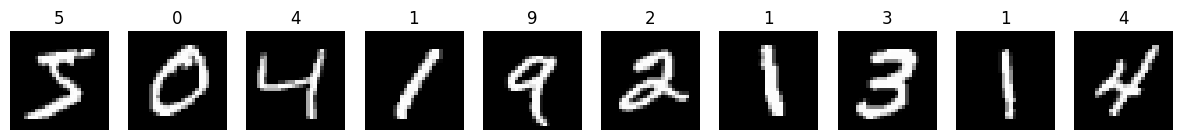

In [4]:
# Affichage des caractéristiques de base du dataset
print(f"Taille du dataset d'entraînement MNIST : {len(mnist_train)}")
print(f"Taille du dataset de test MNIST : {len(mnist_test)}")
print(f"Format des images MNIST : {mnist_train[0][0].size()}")

# Afficher quelques images de MNIST
plt.figure(figsize=(15, 3))
for i in range(10):
    image, label = mnist_train[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.show()


Taille du dataset d'entraînement SVHN : 73257
Taille du dataset de test SVHN : 26032
Format des images SVHN : torch.Size([3, 32, 32])


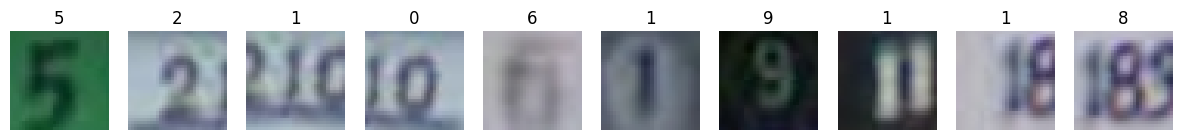

In [5]:
# Affichage des caractéristiques de base du dataset
print(f"Taille du dataset d'entraînement SVHN : {len(svhn_train)}")
print(f"Taille du dataset de test SVHN : {len(svhn_test)}")
print(f"Format des images SVHN : {svhn_train[0][0].size()}")

# Afficher quelques images de SVHN
plt.figure(figsize=(15, 3))
for i in range(10):
    image, label = svhn_test[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.title(label)
    plt.axis('off')
plt.show()


In [6]:
# Définir les transformations (MNIST et SVHN ont des canaux et des tailles d'images différents)
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionner les images MNIST pour correspondre à la taille de SVHN
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_svhn = transforms.Compose([
    # transforms.CenterCrop((28, 28)),  # Redimensionner les images SVHN pour correspondre à la taille de MNIST
    transforms.Grayscale(1),  # Convertir SVHN en niveaux de gris avec un seul canal
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Charger les datasets
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform_mnist)

svhn_train = SVHN(root='./data', split='train', download=True, transform=transform_svhn)
svhn_test = SVHN(root='./data', split='test', download=True, transform=transform_svhn)


Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


# MNIST Pre-processing

In [7]:
def remove_black_col(dataset):
    left_right_cols = []  # Liste pour stocker le nombre de colonnes supprimées à gauche et à droite pour chaque image
    modified_images = []  # Liste pour stocker les images modifiées

    # Fonction pour supprimer les colonnes de pixels noirs et stocker left_col et right_col
    def supprimer_colonnes_nulles(image):
        colonnes_non_nulles = torch.any(image > 0, dim=0)
        left_col = torch.argmax(colonnes_non_nulles.int()).item()
        right_col = len(colonnes_non_nulles) - torch.argmax(colonnes_non_nulles.flip(0).int()).item() - 1
        left_right_cols.append((left_col, right_col))
        return image[:, colonnes_non_nulles]

    print("Suppression des colonnes noires...")
    for image, _ in tqdm(dataset):
        modified_image = supprimer_colonnes_nulles(image.squeeze())
        modified_images.append((modified_image, _))

    return modified_images, left_right_cols

def combine_images(dataset, random_state=None):
    w_original = dataset[0][0].size(2)  # Nombre de colonnes dans les images du dataset d'origine
    print(f"Largeur des images dans le dataset d'origine : {w_original}")
    
    modified_images, left_right_cols = remove_black_col(dataset)
    rng = np.random.RandomState(random_state)
    combined_images = []

    print("Combinaison des images...")
    for (image, label), (n, m) in tqdm(zip(modified_images, left_right_cols)):
        valid_indices = False
        while not valid_indices:
            indices_aleatoires = rng.choice(len(modified_images), 2, replace=False)
            image1, _ = modified_images[indices_aleatoires[0]]
            image2, _ = modified_images[indices_aleatoires[1]]

            # Vérifier si les indices sont valides
            if image1[0].size(0) >= n+1 and image2[0].size(0) >= w_original - m:
                valid_indices = True

        # Ajouter des colonnes supplémentaires pour atteindre les dimensions du dataset d'origine
        new_image = torch.cat((image1[:, -n:], image, image2[:, :w_original-(m+1)]), dim=1)
        combined_images.append((new_image, label))

    # Créer un nouveau dataset avec les images combinées
    transform_resize = transforms.Resize((32, 32))
    combined_images_tensor = [transform_resize(image.unsqueeze(0)) for image, label in combined_images]
    combined_labels_tensor = [label for image, label in combined_images]
    combined_dataset = TensorDataset(torch.stack(combined_images_tensor), torch.tensor(combined_labels_tensor))
    
    w_final = combined_dataset[0][0].size(2)  # Nombre de colonnes dans les images du dataset final
    print(f"Largeur des images dans le dataset final : {w_final}")

    return combined_dataset


In [8]:
# Utilisation de la fonction avec le dataset mnist_train initial
combined_mnist_train = combine_images(mnist_train, random_state=42)

Largeur des images dans le dataset d'origine : 32
Suppression des colonnes noires...


100%|██████████| 60000/60000 [00:09<00:00, 6354.95it/s]


Combinaison des images...


60000it [01:04, 928.84it/s] 


Largeur des images dans le dataset final : 32


Taille du dataset d'entraînement MNIST : 60000
Taille du dataset de test MNIST : 60000
Format des images MNIST : torch.Size([1, 32, 32])


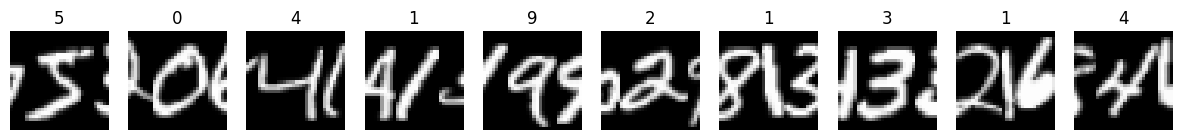

In [9]:
# Affichage des caractéristiques de base du dataset
print(f"Taille du dataset d'entraînement MNIST : {len(combined_mnist_train)}")
print(f"Taille du dataset de test MNIST : {len(combined_mnist_train)}")
print(f"Format des images MNIST : {combined_mnist_train[0][0].size()}")

# Afficher quelques images de MNIST
plt.figure(figsize=(15, 3))
for i in range(10):
    image, label = combined_mnist_train[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(image.squeeze(), cmap='gray')  # Les images MNIST sont en noir et blanc
    plt.title(label.item())
    plt.axis('off')
plt.show()


In [10]:
def transform_mnist(image, x_range=(0.2, 0.8), sig_coeff=4, random_seed=None):
    np.random.seed(random_seed)
    image_np = image.numpy()
    x = np.random.uniform(x_range[0], x_range[1]) # random x in specidied range
    
    # black pixels
    zeros_mask = image_np <= 0.01
    random_values_zeros = np.random.normal(loc=x/2, scale=x/sig_coeff, size=image_np.shape) * zeros_mask
    random_values_zeros[random_values_zeros < 0] = 0  # Assurer que les valeurs restent positives
    
    # gray pixels
    gray_mask = image_np > 0.01
    random_values_gray = np.random.normal(loc=1-(1-x)/2, scale=(1-x)/sig_coeff, size=image_np.shape) * gray_mask
    random_values_gray[random_values_gray > 1] = 1  # Assurer que les valeurs restent dans la plage [0, 1]
    
    # Final values
    new_image_np = random_values_zeros + random_values_gray
    new_image_np = np.clip(new_image_np, 0, 1)

    new_image = torch.tensor(new_image_np)
    
    return new_image

def modified_mnist_images(dataset, x_range=(0.2, 0.8), sig_coeff=4, data_aug=1, random_seed=None):
    new_dataset = []
    for image, label in tqdm(dataset):
        transformed_images = [transform_mnist(image, x_range, sig_coeff, random_seed) for _ in range(data_aug)]
        new_dataset.extend([(image, label) for image in transformed_images])
    complementary_dataset = [(1 - image, label) for image, label in tqdm(new_dataset)]
    mnist_modified = new_dataset + complementary_dataset
    np.random.shuffle(mnist_modified)
        
    return mnist_modified


In [11]:
custom_mnist_train = modified_mnist_images(combined_mnist_train, x_range=(0.1, 0.9), sig_coeff=10, data_aug=3)
print(f"Taille du nouveau dataset d'entrainement MNIST: {len(custom_mnist_train)}")

100%|██████████| 180000/180000 [00:01<00:00, 98143.75it/s] 


Taille du nouveau dataset d'entrainement MNIST: 360000


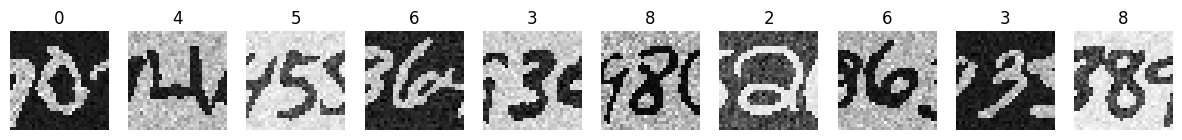

In [12]:
# Afficher quelques images de MNIST custom
plt.figure(figsize=(15, 6))
for i in range(10):
    image, label = custom_mnist_train[i]
    plt.subplot(1, 10, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(label.item())
    plt.axis('off')
plt.show()

# SVHN Pre-processing

In [13]:
def transform_svhn(image, x_range=(0.2, 0.8), sig_coeff=4, threshold=0.2, random_seed=None):
    np.random.seed(random_seed)
    image_np = (image.numpy()+1)/2  # Convertir les valeurs de [-1, 1] à [0, 1]
    x = np.random.uniform(x_range[0], x_range[1]) # random x in specidied range
    
    # pixels under the threshold
    zeros_mask = image_np <= threshold
    random_values_zeros = np.random.normal(loc=x/2, scale=x/sig_coeff, size=image_np.shape) * zeros_mask
    random_values_zeros[random_values_zeros < 0] = 0  # Assurer que les valeurs restent positives
    
    # pixels above the threshold
    gray_mask = image_np > threshold
    random_values_gray = np.random.normal(loc=1-(1-x)/2, scale=(1-x)/sig_coeff, size=image_np.shape) * gray_mask
    random_values_gray[random_values_gray > 1] = 1  # Assurer que les valeurs restent dans la plage [0, 1]
    
    # Final values
    new_image_np = random_values_zeros + random_values_gray
    new_image_np = np.clip(new_image_np, 0, 1)
    
    new_image = torch.tensor(new_image_np)
    
    return new_image


def modified_svhn_images(dataset, x_range=(0.2, 0.8), sig_coeff=4, thresholds=np.arange(0.05, 1.0, 0.05), random_seed=None):
    svhn_modified = []
    for image, label in tqdm(dataset):
        transformed_images = []
        for threshold in thresholds:
            transformed_image = transform_svhn(image, x_range, sig_coeff, threshold, random_seed)
            transformed_images.append(transformed_image)
        svhn_modified.append((transformed_images, label))
 
    return svhn_modified


In [14]:
custom_svhn_test = modified_svhn_images(svhn_test, x_range=(0.1, 0.9), sig_coeff=10, thresholds=np.arange(0.05, 1.0, 0.05))
print(f"Taille du nouveau dataset de test SVHN: {len(custom_svhn_test)}")

100%|██████████| 26032/26032 [01:29<00:00, 292.47it/s]

Taille du nouveau dataset de test SVHN: 26032


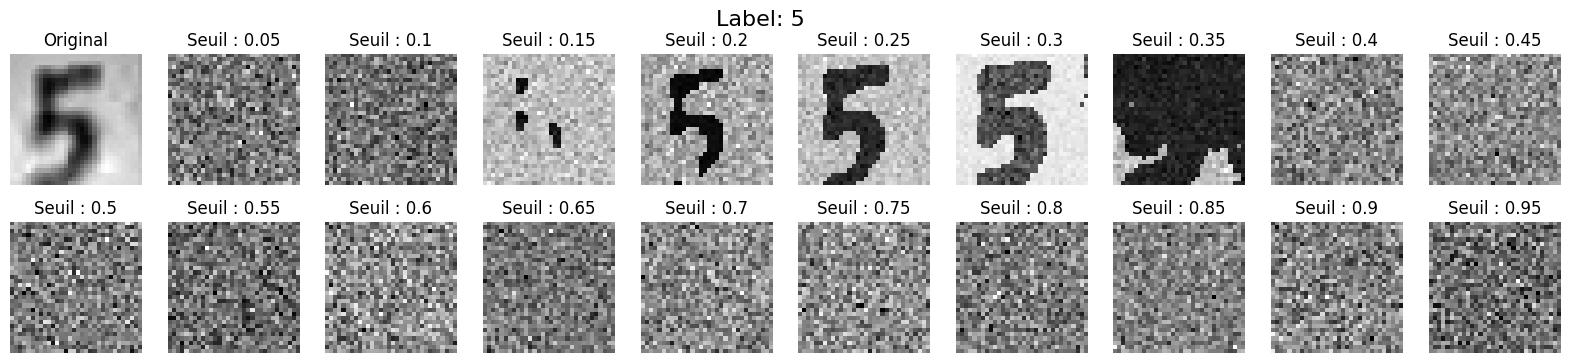

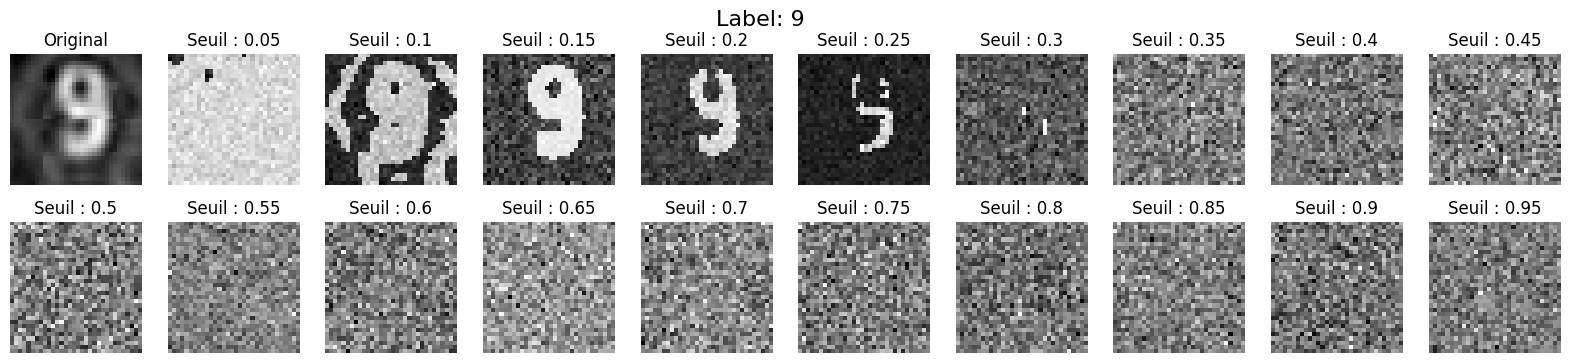

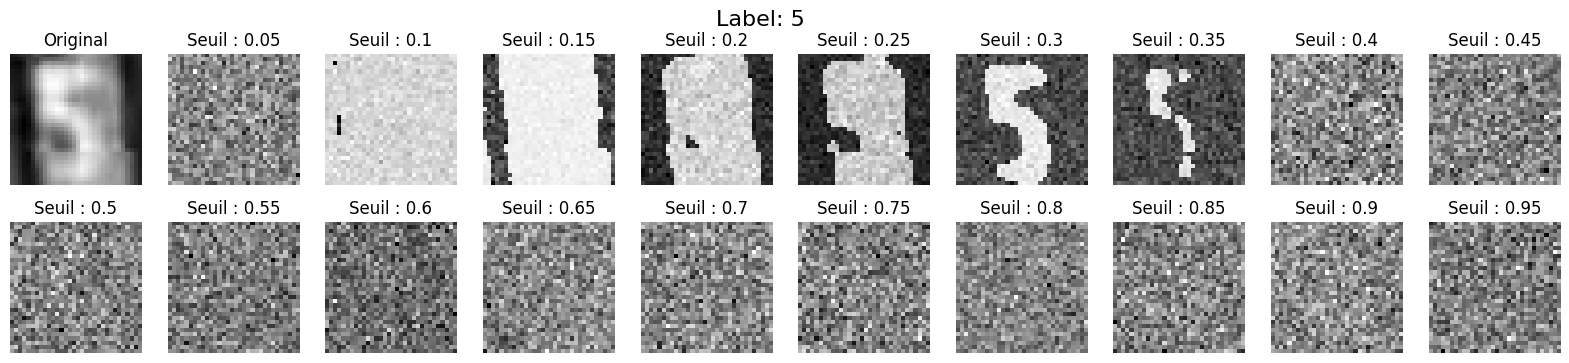

In [15]:
def show_images_with_label(images_orig, images_transform_list, label):
    plt.figure(figsize=(20, 4))
    plt.suptitle(f"Label: {label}", fontsize=16)
    plt.subplot(2, 10, 1)
    plt.imshow(images_orig.permute(1, 2, 0).numpy(), cmap='gray')
    plt.title(f"Original")
    plt.axis('off')
    for i, image in enumerate(images_transform_list):
        plt.subplot(2, 10, i+2)
        plt.imshow(image.permute(1, 2, 0).numpy(), cmap='gray')
        plt.title(f"Seuil : {np.round(0.05 + i*0.05, 2)}")
        plt.axis('off')
    plt.show()

# Afficher trois exemples d'observations générées pour SVHN custom
for i in range(3):
    n=6
    images_orig, label = svhn_test[i*n]
    images_transform_list, _ = custom_svhn_test[i*n]
    show_images_with_label(images_orig, images_transform_list, label)


# Classification models and training

In [16]:
# Creation of a simple CNN model to evaluate the different methods

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.fc1 = nn.Linear(128 * 5 * 5, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 128 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
# Model training with the original MNIST dataset

batch_size = 256
train_loader_mnist_orig = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
model_orig = SimpleCNN().to(device)

optimizer = torch.optim.Adam(model_orig.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(1):  # 1 epoch is optimal here to avoid overfitting on mnist and allow a better generalization on svhn
    for data, target in train_loader_mnist_orig:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        data = data.float()
        output = model_orig(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')
    
model_orig.to('cpu') 


Epoch 0, Loss: 0.06841617822647095


SimpleCNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [18]:
# Model training with the custom MNIST dataset

batch_size = 256
train_loader_mnist_custom = DataLoader(custom_mnist_train, batch_size=batch_size, shuffle=True)
model_custom = SimpleCNN().to(device)

optimizer = torch.optim.Adam(model_custom.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):  # Several trials show than 10 epochs are a good trade-off between model fitting and generalization
    for data, target in train_loader_mnist_custom:
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        data = data.float()
        output = model_custom(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')
    
model_custom.to('cpu') 


Epoch 0, Loss: 0.00693990383297205
Epoch 1, Loss: 0.015708452090620995
Epoch 2, Loss: 0.004715877119451761
Epoch 3, Loss: 0.040045104920864105
Epoch 4, Loss: 0.008999787271022797
Epoch 5, Loss: 0.00019057073222938925
Epoch 6, Loss: 0.00010028611723100767
Epoch 7, Loss: 6.947545898583485e-07
Epoch 8, Loss: 2.0637673969758907e-06
Epoch 9, Loss: 7.3586052167229354e-06


SimpleCNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

# Results

In [19]:
ex_nb = len(svhn_test)
# ex_nb = 100
correct_mnist_orig = 0
correct_mnist_custom_svhn_orig = 0
correct_mnist_custom_svhn_custom = 0
model_orig.to(device)
model_custom.to(device)

print("MNIST Original - SVHN Original")

with torch.no_grad():
    for i in tqdm(range(ex_nb)):
        svhn_orig_image, svhn_orig_label = svhn_test[i]
        svhn_orig_image = svhn_orig_image.to(device)
        # plt.figure(figsize=(2, 2))
        # plt.imshow(np.transpose(svhn_orig_image, (1, 2, 0)), cmap='gray')
        # plt.show()
        y_pred = model_orig(svhn_orig_image.unsqueeze(0).float()).argmax().item()
        # print(f"True Label: {svhn_orig_label}, Predicted Label: {y_pred}   {y_pred == svhn_orig_label}")
        if y_pred == svhn_orig_label:
            correct_mnist_orig += 1
    
print(f"Accuracy: {correct_mnist_orig/ex_nb*100:.2f}%")

print("\nMNIST Custom - SVHN Original")

with torch.no_grad():
    for i in tqdm(range(ex_nb)):
        svhn_orig_image, svhn_orig_label = svhn_test[i]
        svhn_orig_image = svhn_orig_image.to(device)
        # plt.figure(figsize=(2, 2))
        # plt.imshow(np.transpose(svhn_orig_image, (1, 2, 0)), cmap='gray')
        # plt.show()
        y_pred = model_custom(svhn_orig_image.unsqueeze(0).float()).argmax().item()
        # print(f"True Label: {svhn_orig_label}, Predicted Label: {y_pred}   {y_pred == svhn_orig_label}")
        if y_pred == svhn_orig_label:
            correct_mnist_custom_svhn_orig += 1
    
print(f"Accuracy: {correct_mnist_custom_svhn_orig/ex_nb*100:.2f}%")
         
print("\nMNIST Custom - SVHN Custom")

with torch.no_grad():
    for i in tqdm(range(ex_nb)):
        svhn_custom_image, svhn_custom_label = custom_svhn_test[i]
        y_probs = []
        for image in svhn_custom_image:
            image = image.to(device)
            y_probs.append(F.softmax(model_custom(image.unsqueeze(0).float()), dim=1))
        y_probs = torch.stack(y_probs)
        y_pred = torch.argmax(torch.max(y_probs, dim=0).values)
        idx_max = torch.argmax(y_probs, dim=0)[0][y_pred]
        # if y_pred.item() != svhn_custom_label:
        #     plt.figure(figsize=(2, 2))
        #     plt.imshow(np.transpose(svhn_custom_image[idx_max], (1, 2, 0)), cmap='gray')
        #     plt.show()
        #     print(f"True Label: {svhn_custom_label}, Predicted Label: {y_pred.item()} ({np.round(100*torch.max(y_probs[idx_max]).item(), 1)}%)   {y_pred.item() == svhn_custom_label}")
        if y_pred.item() == svhn_custom_label:
            correct_mnist_custom_svhn_custom += 1
            
print(f"Accuracy: {correct_mnist_custom_svhn_custom/ex_nb*100:.2f}%")


MNIST Original - SVHN Original


  0%|          | 0/26032 [00:00<?, ?it/s]

100%|██████████| 26032/26032 [00:50<00:00, 517.45it/s] 


Accuracy: 34.46%

MNIST Custom - SVHN Original


100%|██████████| 26032/26032 [00:18<00:00, 1432.63it/s]


Accuracy: 53.97%

MNIST Custom - SVHN Custom


100%|██████████| 26032/26032 [08:07<00:00, 53.45it/s] 

Accuracy: 59.09%
